# Lab 4

## Подготовка данных

### Импортирем нужные библиотеки

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
pass

### Читаем "входное" изображение

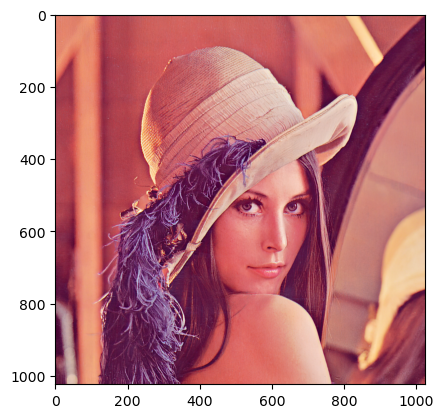

In [2]:
image = cv2.imread("lena.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
pass

Для удобства вычислений в будущем поменяем форму изображения: (h, w, c) -> (c, h, w)

In [3]:
image.shape

(1024, 1024, 3)

### Вспомогательная функция обрезки значения
Параметры:
* _value_ - значение
* _lb_ - левая граница
* _rb_ - правая граница
* _l\_val_ - значение, возвращаемое, если значение меньше левой границы
* _r\_val_ - значение, возвращаемое, если значение больше правой границы

In [4]:
def clip(value, lb, rb, l_val, r_val):
    if lb > rb:
        print("Can't clip a value!")
    if value < lb:
        return l_val
    if value > rb:
        return r_val
    return value

## Вспомогательные классы
Для всех них предполагается, что _image.shape == (c, h, w)_, где _с_ - число каналов, _h_ - высота изображения, _w_ - ширина изображения

### Свертка (Convolution)
Параметры инициализации:
* _c\_in_ - колчичество входных каналов (если RGB-изображение, то _c\_in_ = 3)
* _c\_out_ - количество выходных каналов (равно результирующему количеству фильтров)
* _kernel\_size_ - размер ядра свертки

In [5]:
class Conv:
    def __init__(self, c_in, c_out, kernel_size):
        self.c_in = c_in
        self.c_out = c_out
        self.kernel_size = kernel_size
        self.weights = np.random.rand(c_out, c_in, kernel_size, kernel_size)
        self.bias = np.random.rand(c_out)
        
        
    def __calculate_conv_value(self, m, image, x, y):
        result = 0
        h, w = image.shape[1:]
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                for k in range(self.c_in):
                    x_idx = clip(x - (self.kernel_size // 2) + i, 0, h - 1, 0, 0)
                    y_idx = clip(y - (self.kernel_size // 2) + j, 0, w - 1, 0, 0)
                    result += image[k, x_idx, y_idx] * self.weights[m, k, i, j]
        return result
    
    
    def __call__(self, image):
        c, h, w = image.shape
        if (c != self.c_in):
            print("Can't apply a convolution over an input image!")
            return
        result = np.zeros((self.c_out, h, w))
        for m in range(self.c_out):
            for x in range(h):
                for y in range(w):
                    result[m, x, y] = self.bias[m] + self.__calculate_conv_value(m, image, x, y)
        return result

### Нормализация

$$\mu_{m} = \frac{1}{HW}\sum\limits_{x=0}^{H-1}\sum\limits_{y=0}^{W-1}I_{m, x, y}$$

$$D_{m} = \frac{1}{HW}\sum\limits_{x=0}^{H-1}\sum\limits_{y=0}^{W-1}(I_{m, x, y} - \mu_{m})^2$$

$$\hat{I}_{m, x, y} = \frac{I_{m, x, y} - \mu_{m}}{\sqrt{D_{m}+\epsilon}}$$

$$Result_{m, x, y} = \gamma_{m}\hat{I}_{m, x, y} + \beta_{m}$$

Параметры инициализации:
* _c\_norm_ - количество каналов (фильтров)
* _eps_ - малое значение, добавляемое к значению дисперсии, что обезопаситься от случая, когда она равна нулю (ведь в таком случае будет деление на ноль). Данный параметр необязательный и по умолчанию равен 0.00001

In [6]:
class Norm:
    def __init__(self, c_norm, eps=0.00001):
        self.eps = eps
        self.gamma = np.random.rand((c_norm))
        self.beta = np.random.rand((c_norm))
    
    
    def __calculate_mean(self, m, image):
        result = 0.0
        h, w = image.shape[1:]
        for x in range(h):
            for y in range(w):
                result += image[m, x, y]
        result /= (h * w)
        return result
    
    
    def __calculate_var(self, m, image, mean):
        result = 0.0
        h, w = image.shape[1:]
        for x in range(h):
            for y in range(w):
                result += (image[m, x, y] - mean) ** 2
        result /= (h * w)
        return result
    
    
    def __scale_val(self, val, mean, var):
        result = 0.0
        std = (var + self.eps) ** 0.5
        result = (val - mean) / std
        return result
    
    
    def __call__(self, image):
        c, h, w = image.shape
        result = np.zeros((c, h, w))
        mean = np.zeros((c))
        var = np.zeros((c))
        for m in range(c):
            mean = self.__calculate_mean(m, image)
            var = self.__calculate_var(m, image, mean)
            for x in range(h):
                for y in range(w):
                    result[m, x, y] = self.beta[m] + \
                        self.gamma[m] * self.__scale_val(image[m, x, y], mean, var)
        return result

### ReLU

$$ReLU(x) = \max(0, x)$$

Параметров инициализации как таковых нет

In [7]:
class ReLU:
    def __init__(self):
        pass
    
    
    def __call__(self, image):
        c, h, w = image.shape
        result = np.zeros((c, h, w))
        for m in range(c):
            for x in range(h):
                for y in range(w):
                    result[m, x, y] = max(0, image[m, x, y])
        return result

### MaxPooling

Параметры инициализации:
* _kernel\_size_ - размер ядра

In [8]:
class MaxPooling:
    def __init__(self, kernel_size=2):
        self.kernel_size = kernel_size
        
        
    def __calculate_max_value(self, m, image, x, y):
        result = 0
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                x_idx = self.kernel_size * x + i
                y_idx = self.kernel_size * y + j
                result = max(result, image[m, x_idx, y_idx])
        return result
    
    
    def __call__(self, image):
        c, h, w = image.shape
        h_new = h // self.kernel_size
        w_new = w // self.kernel_size
        result = np.zeros((c, h_new, w_new))
        for m in range(c):
            for x in range(h_new):
                for y in range(w_new):
                    result[m, x, y] = self.__calculate_max_value(m, image, x, y)
        return result

### SoftMax

$$SoftMax(I_{m, x, y}) = \frac{\exp(I_{m, x, y})}{\sum_{m}^{}\exp(I_{m, x, y})}$$

Параметров инициализации как таковых нет

In [9]:
class SoftMax:
    def __init__(self):
        pass
    
    
    def __calculate_exp_sum(self, image, x, y):
        result = 0
        c = image.shape[0]
        for m in range(c):
            result += math.exp(image[m, x, y])
        return result
    
    
    def __call__(self, image):
        c, h, w = image.shape
        result = np.zeros((c, h, w))
        for x in range(h):
            for y in range(w):
                exp_sum = self.__calculate_exp_sum(image, x, y)
                for m in range(c):
                    result[m, x, y] = math.exp(image[m, x, y]) / exp_sum
        return result

## Применение преобразований
Поочередно применим каждое из этих преобразований к исходному изображению (точнее к "транспонированному" исходному изображению)

In [10]:
image.shape

(1024, 1024, 3)

In [11]:
image_t = np.transpose(image, (2, 0, 1))
image_t.shape

(3, 1024, 1024)

Применяем ___свертку___ с 5 фильтрами 3x3x3 (случайные числа)

In [12]:
conv = Conv(3, 5, 3)
C_res = conv(image_t)
C_res.shape

(5, 1024, 1024)

К результату свертки применяем ___нормализацию___

In [13]:
norm = Norm(5)
N_res = norm(C_res)
N_res.shape

(5, 1024, 1024)

К результату нормализации применяем ___ReLU___

In [14]:
relu = ReLU()
R_res = relu(N_res)
R_res.shape

(5, 1024, 1024)

In [15]:
R_res[0, 0:4, 0:4]

array([[1.29564097, 1.27032138, 1.26210635, 1.27650464],
       [1.28505766, 1.26413222, 1.25966029, 1.28206817],
       [1.29060098, 1.27267139, 1.25860123, 1.26681117],
       [1.29557688, 1.29278603, 1.27262356, 1.2734997 ]])

К результату нормализации применяем ___MaxPooling___ (2x2)

In [16]:
max_pool = MaxPooling()
M_res = max_pool(R_res)
M_res.shape

(5, 512, 512)

In [17]:
M_res[0, 0:2, 0:2]

array([[1.29564097, 1.28206817],
       [1.29557688, 1.2734997 ]])

К результату нормализации применяем попиксельный ___SoftMax___

In [18]:
softmax = SoftMax()
S_res = softmax(M_res)
S_res.shape

(5, 512, 512)

In [19]:
S_res

array([[[0.26607208, 0.26511416, 0.26475248, ..., 0.24310149,
         0.23604713, 0.23232965],
        [0.26660068, 0.26402517, 0.26550189, ..., 0.23793744,
         0.22572318, 0.21422197],
        [0.26581695, 0.26417158, 0.26504347, ..., 0.22858879,
         0.20770419, 0.19191758],
        ...,
        [0.16965693, 0.16949524, 0.16862814, ..., 0.20014794,
         0.19759349, 0.2019724 ],
        [0.16984273, 0.16949598, 0.16853875, ..., 0.20353766,
         0.20937786, 0.21376861],
        [0.16231652, 0.16156527, 0.15869721, ..., 0.21462242,
         0.21464467, 0.21261621]],

       [[0.23131166, 0.23155039, 0.2328342 , ..., 0.22682184,
         0.2212542 , 0.22363489],
        [0.231279  , 0.23233477, 0.23202336, ..., 0.22249888,
         0.21676247, 0.21832224],
        [0.23185792, 0.23089436, 0.23280105, ..., 0.22063967,
         0.20696719, 0.20514093],
        ...,
        [0.16965693, 0.16949524, 0.16862814, ..., 0.20785039,
         0.20696093, 0.21170213],
        [0.1

Для удобства объединим все преобразования в едином классе ___Net___

In [20]:
class Net:
    def __init__(self, c_out):
        self.conv = Conv(3, c_out, 3)
        self.norm = Norm(c_out)
        self.relu = ReLU()
        self.max_pool = MaxPooling()
        self.softmax = SoftMax()
    
    
    def preprocess_image(self, image):
        return np.transpose(image, (2, 0, 1))
    
    
    def __call__(self, image):
        x = self.preprocess_image(image)
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.softmax(x)
        return x

Теперь эти же преобразования можно провести более удобным способом

In [21]:
count_of_filters = 5
net = Net(count_of_filters)
result = net(image)

In [23]:
result.shape

(5, 512, 512)

In [24]:
result

array([[[0.19979321, 0.2006264 , 0.19918762, ..., 0.21145022,
         0.21663399, 0.21931158],
        [0.19997639, 0.20049106, 0.1987278 , ..., 0.2145145 ,
         0.22156556, 0.22868179],
        [0.19995427, 0.20000478, 0.19941585, ..., 0.21961145,
         0.22953673, 0.23505962],
        ...,
        [0.219408  , 0.22121867, 0.22607035, ..., 0.23108075,
         0.230442  , 0.22932682],
        [0.21760403, 0.22149258, 0.22720768, ..., 0.23087807,
         0.22785485, 0.22785111],
        [0.22942249, 0.22974577, 0.2293087 , ..., 0.22292911,
         0.22410147, 0.22604677]],

       [[0.16781543, 0.16703419, 0.16742478, ..., 0.1607598 ,
         0.15877153, 0.15811195],
        [0.1676135 , 0.16724369, 0.16773508, ..., 0.15970874,
         0.15605444, 0.15334727],
        [0.16767515, 0.16769051, 0.16811956, ..., 0.15664719,
         0.15173824, 0.15428433],
        ...,
        [0.195148  , 0.19469533, 0.19348241, ..., 0.15024873,
         0.15037305, 0.15069135],
        [0.1